In [0]:
##Author : Ria Thomas
##Master's in Computer Science with Big Data 
##Simon Fraser University, Burnaby
##Created on : April 13, 2020

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Use the file generated for evaluation
anomaly = pd.read_csv('Sample_test_data.csv')

In [0]:
anomaly.rename(columns={ anomaly.columns[0]: 'Pos',anomaly.columns[1]: 'Value',anomaly.columns[2]: 'Anomaly'}, inplace=True)


In [0]:
anomaly = anomaly.iloc[1520:]

In [0]:
anomaly

,Pos,Value,Anomaly
0,35:27.0,0.789063,0
1,35:27.0,0.785156,0
2,35:27.1,0.781250,0
3,35:27.1,0.785156,0
4,35:27.1,0.789063,0
...,...,...,...
1515,36:26.8,0.781250,0
1516,36:26.8,0.804688,0
1517,36:26.8,0.777344,0
1518,36:26.9,0.773438,0


In [0]:
# Standard scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True,with_std=True)
anomaly['Value_scaled'] = scaler.fit_transform(anomaly[['Value']])

In [0]:
# Apply moving average

anomaly['movingAverage'] = anomaly['Value_scaled'].rolling(3).mean()
anomaly.dropna(inplace=True)

In [0]:
test = anomaly[['Pos','movingAverage']]

In [0]:
# Load the model
from tensorflow.python.keras.models import model_from_json
json_file = open('/content/drive/My Drive/LSTM_model_T3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/drive/My Drive/LSTM_weights_T3.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [0]:
TIME_STEPS = 5
X_test, y_test = create_dataset(
  test[['movingAverage']],
  test.movingAverage,
  TIME_STEPS
)

In [0]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [0]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [0]:
threshold = 1.3338202437285336     # Calculated from 95th percentile of training loss
test_score_df = pd.DataFrame(index=test[5:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['movAverage'] = test[5:].movingAverage

In [0]:
anomalies = test_score_df[test_score_df.anomaly == True]

In [0]:
anomaly.reset_index(inplace=True)
test_score_df.reset_index(inplace=True)

In [0]:
df_final = pd.merge(anomaly,test_score_df,on='index')

In [0]:
df_final['anomaly']=df_final['anomaly'].astype(int)

In [0]:
df_final = df_final[['Pos','Value','anomaly']]

In [0]:
df_final

,Pos,Value,anomaly
0,35:27.3,0.785156,0
1,35:27.3,0.785156,0
2,35:27.3,0.781250,0
3,35:27.4,0.781250,0
4,35:27.4,0.781250,0
...,...,...,...
1508,36:26.8,0.781250,0
1509,36:26.8,0.804688,0
1510,36:26.8,0.777344,0
1511,36:26.9,0.773438,0


No handles with labels found to put in legend.


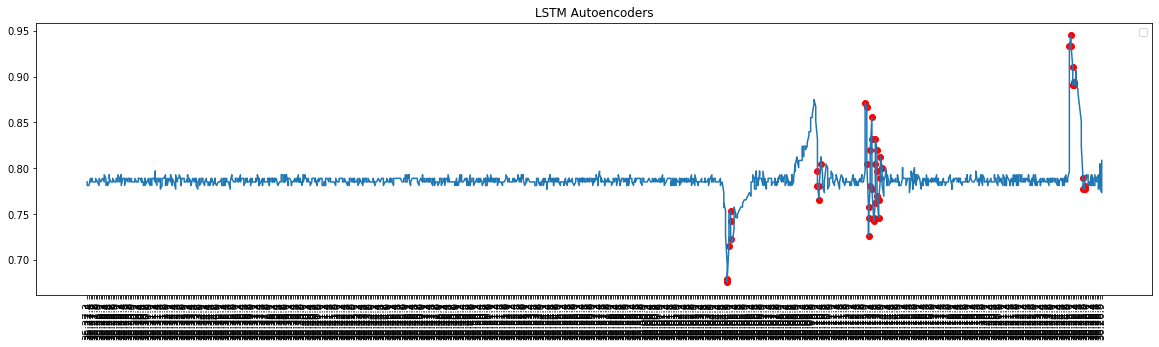

In [0]:
plt.plot(df_final['Pos'],df_final['Value'],'-')
plt.scatter(df_final.Pos[df_final.anomaly==True], df_final.Value[df_final.anomaly==True],marker='o',c='red')
plt.title('LSTM Autoencoders')
plt.xticks(rotation = 90)
plt.legend();

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_true = anomaly['Anomaly'] 
y_true = y_true[5:]   # the true anomaly column(0/1)
y_pred = df_final['anomaly']    # the predicted anomaly column

In [0]:
# Find the confusion matrix

tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()

In [0]:
print("True negatives :",tn)
print("False positives :",fp)
print("True positives :",fn)
print("False negatives :",tp)

True negatives : 1449
False positives : 15
True positives : 17
False negatives : 32


In [0]:
# Calculate precision and recall

precision = tp/(tp + fp)
recall = tp/(tp + fn) 

In [0]:
precision

0.6808510638297872

In [0]:
recall

0.6530612244897959

In [0]:
f1_score = (2*(precision * recall))/(precision + recall)

In [0]:
f1_score

0.6666666666666666